# Script to train an AutoEncoder for the CIFAR-10 dataset. 
-------------------------------------------------------------------------------------------------------------------
### Technology used: Tensorflow-core 

In [1]:
# packages used for machine learning
import tensorflow as tf

# packages used for processing: 
from six.moves import cPickle as pickle # for reading the data
import matplotlib.pyplot as plt # for visualization
import numpy as np
from sklearn.preprocessing import OneHotEncoder # for encoding the labels in one hot form

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '..'])

Data
LICENSE
Models
README.md
requirements.txt
Scripts



In [4]:
''' Set the constants for the script '''

# various paths of the files
data_path = "../Data/cifar-10-batches-py" # the data path
train_meta = os.path.join(data_path, "batches.meta")
base_model_path = '../Models'

# constant values:
size = 32 # the images of size 32 x 32
channels = 3 # RGB channels
highest_pixel_value = 255.0 # 8 bits for every channel. So, max value is 255
no_of_epochs = 100 # No. of epochs to run
no_of_batches = 5 # There are 5 batches in the dataset
checkpoint_factor = 5 # save the model after every 5 steps (epochs)

In [5]:
# check the contents inside the data folder
exec_command(['ls', data_path])

batches.meta
data_batch_1
data_batch_2
data_batch_3
data_batch_4
data_batch_5
readme.html
test_batch



In [6]:
# function to unPickle a file: 
def unpickle(file):
    '''
        This function takes the file path and unPickles the file acquired from it
        @Param file: the string path of the file
        @return: The dict object unPickled from the file
    '''
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

### Let's check the contents of the batches.meta file

In [7]:
meta_data = unpickle(train_meta)

# check it's contents
meta_data

{'label_names': ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 'num_cases_per_batch': 10000,
 'num_vis': 3072}

### Let's read and display some of the images from the dataset along with their labels

In [8]:
train_batch_preliminary = unpickle(os.path.join(data_path, "data_batch_3"))

# check it's contents
train_batch_preliminary.keys()

['data', 'labels', 'batch_label', 'filenames']

In [9]:
# Extract the first 3 images from the dataset
preliminary_data = train_batch_preliminary['data'].reshape((len(train_batch_preliminary['data']), 32, 32, 3), 
                                                           order='F')
preliminary_labels = train_batch_preliminary['labels']

# view some of the data:
preliminary_data[33, :10, :10, 2] #(10 x 10) data of blue channel of 33rd image

array([[178, 191, 193, 197, 202, 206, 207, 209, 214, 219],
       [140, 151, 155, 160, 166, 172, 173, 171, 176, 180],
       [ 84,  94, 119, 151, 146, 127, 125, 135, 139, 139],
       [ 16,  18,  85, 200, 207, 133,  71,  59,  72,  79],
       [  9,   3,  51, 183, 238, 219, 177,  94,  30,  16],
       [ 31,  25,  38, 148, 240, 249, 255, 235, 139,  39],
       [ 69,  65,  62, 115, 215, 250, 248, 253, 245, 201],
       [ 92,  89,  81,  89, 173, 240, 249, 253, 253, 255],
       [ 93,  90,  84,  85, 139, 217, 241, 246, 251, 252],
       [ 75,  74,  71,  87, 154, 208, 229, 239, 245, 250]], dtype=uint8)

In [10]:
# check a few values of the labels of the dataset
preliminary_labels[:10] 

[8, 5, 0, 6, 9, 2, 8, 3, 6, 2]

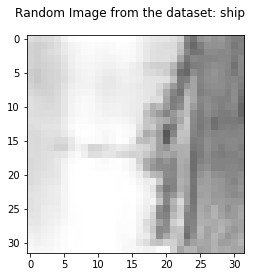

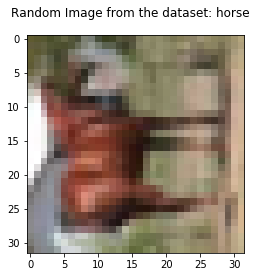

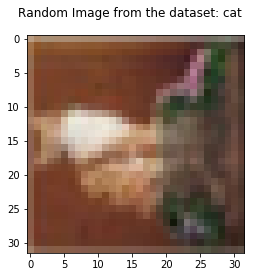

In [11]:
for _ in range(3):
    random_index = np.random.randint(preliminary_data.shape[0])
    
    plt.figure().suptitle("Random Image from the dataset: %s" %(meta_data['label_names'][preliminary_labels[random_index]]))
    plt.imshow(preliminary_data[random_index], interpolation='none')

### The images look blurred out because they are very low resolution images (32 x 32) pixels only.

## It can be seen that the images in the original dataset are skewed. So, we will have to rotate them by 90 degrees clockwise

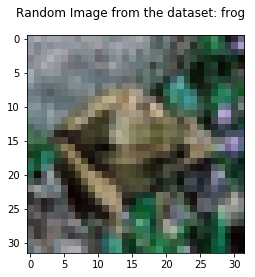

In [12]:
# let's try using the numpy.rot90 method for this:
random_index = np.random.randint(preliminary_data.shape[0])
    
plt.figure().suptitle("Random Image from the dataset: %s" %(meta_data['label_names'][preliminary_labels[random_index]]))
plt.imshow(np.rot90(preliminary_data[random_index], axes=(1, 0)), interpolation='none'); # suppress the unnecessary
# output

This works. So, now we can create a function to put all this together. This function would take the batch pickle file and create the data suitable for feeding it off to a convolutional neural network.

In [21]:
# The batch generator function:
def generateBatch(batchFile):
    '''
        The function to generate a batch of data suitable for performing the convNet operations on it
        @param batchFile -> the path of the input batchfile
        @return batch: (data, labels) -> the processed data.
    '''
    # unpickle the batch file:
    data_dict = unpickle(batchFile)
    
    # extract the data and labels from this dictionary
    unprocessed_data = data_dict['data']
    integer_labels = np.array(data_dict['labels']) # labels in integer form
    
    # reshape and rotate the data
    data = unprocessed_data.reshape((len(unprocessed_data), size, size, channels), order='F')
    processed_data = np.array(map(lambda x: np.rot90(x, axes=(1, 0)), data))
    
    # normalize the images by dividing all the pixels by 255
    processed_data = processed_data.astype(np.float32) / 255
    
    # encode the labels in one-hot encoded form
    # we use the sklearn.preprocessing package for doing this
    encoder = OneHotEncoder(sparse=False)
    encoded_labels = np.array(encoder.fit_transform(integer_labels.reshape(len(integer_labels), 1))).astype(np.int)
    
    # return the processed data and the encoded_labels:
    return (processed_data, encoded_labels)

### Time to test this function

In [22]:
# load the batch no. 1 and check if it works correctly.
batch_data, batch_labels = generateBatch(os.path.join(data_path, "data_batch_1"))
print (batch_data.shape, batch_labels.shape)

# batch_data[0, :12, :12, 2]

((10000, 32, 32, 3), (10000, 10))


Random image shape: (32, 32, 3)
Random image dataTypefloat32


check if the data has been properly normalized
[[ 0.70980394  0.72156864  0.72156864]
 [ 0.65098041  0.65098041  0.66666669]
 [ 0.63529414  0.61960787  0.627451  ]]


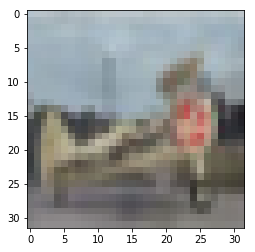

In [43]:
# extract one image from the data and display it
randomIndex = np.random.randint(batch_data.shape[0])
randomImage = batch_data[randomIndex]
print "Random image shape: " + str(randomImage.shape)

print "Random image dataType" + str(randomImage.dtype)

print "\n\ncheck if the data has been properly normalized"
print randomImage[:3, :3, 0]

# Visualize the random image from the dataset
plt.figure()
plt.imshow(randomImage, interpolation='none'); # suppress the unnecessary

Alright! So, the data extraction module is setup. Let's move on to the actual model building and training.

# The computation graph (tensorflow graph and not the weights) for this model is inside the computation_graph package. It can be imported from there

In [44]:
# import the graph from the Graph1 module 
import computation_graph.Graph1 

computation_graph = computation_graph.Graph1.graph

# obtain a handle on the encoded_representation tensor of the dataflow computation graph
encoded_representation = computation_graph.get_tensor_by_name("encoded_representation:0")
encoded_representation.shape # The output shape of the encoded representation. It is 32 x 2 x 2 i.e 128 
# Thus the latent representation is 128 dimensional

TensorShape([Dimension(None), Dimension(2), Dimension(2), Dimension(32)])

In [45]:
model_path = os.path.join(base_model_path, "Model1")

## Now, let's write the session code to run this computation graph and perform the training

In [ ]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. Since, the data used for this task is CIFAR-10, 
    This cell will take a really really long time on low-end machines. It will however not crash your pc, since 
    I have bootstrapped the training in such a way that it loads a small chunk of data at a time to train.
    
    It took me around 5hrs to execute this cell entirely.
'''

with tf.Session(graph=computation_graph) as sess:
    
    if(os.path.isfile(os.path.join(model_path, "checkpoint"))):
         # load the weights from the model1
        saver = tf.train.Saver(max_to_keep=2)

        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
    
    else:
        # create a new saver
        saver = tf.train.Saver(max_to_keep=2)
        
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    for ep in range(50, no_of_epochs):  # epochs loop
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
        for batch_n in range(no_of_batches):  # batches loop
            
            # retrieve the operations from the graph to be evaluated
            loss = sess.graph.get_tensor_by_name("loss:0")
            train_op = sess.graph.get_operation_by_name("train_op")
            inputs = sess.graph.get_tensor_by_name("inputs:0")
            
            # generate the batch images and labels
            batch_images, batch_labels = generateBatch(os.path.join(data_path, "data_batch_" + str(batch_n + 1)))
            
            min_batch_size = 2000 # we look at only 500 images at a time since the machine is small
            
            print "current_batch: " + str(batch_n + 1)
            
            for index in range(len(batch_images) / min_batch_size):
                start = index * min_batch_size
                end = start + min_batch_size
                _, cost = sess.run([train_op, loss], feed_dict={inputs: batch_images[start: end]})
                print('range:{} loss= {}'.format((start, end), cost))
            
            print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0):
            # save the model trained so far:
            saver.save(sess, os.path.join(model_path, "model1"), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="

# Let's visualize the representation of a random image and it's reconstructed form

INFO:tensorflow:Restoring parameters from ../Models/Model1/model1-100


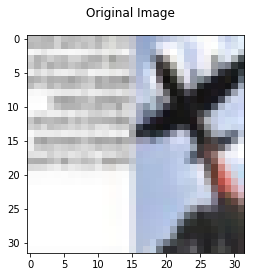

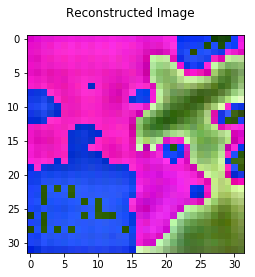

In [47]:
with tf.Session(graph = computation_graph) as sess:
    # load the weights from the model1
    saver = tf.train.Saver()
    
    # instead of global variable initializer, restore the graph:
    saver.restore(sess, tf.train.latest_checkpoint(model_path))
    
    prediction = sess.graph.get_tensor_by_name("prediction:0")
    inputs = sess.graph.get_tensor_by_name("inputs:0")
    
    random_image = batch_data[np.random.randint(len(batch_data))]
    reconstructed_image = sess.run(prediction, feed_dict={inputs: np.array([random_image])})[0]
    
    # plot the two images with their titles:
    plt.figure().suptitle("Original Image")
    plt.imshow(random_image, interpolation='none')
    
    plt.figure().suptitle("Reconstructed Image")
    plt.imshow(reconstructed_image, interpolation='none')

# Use the 2nd model that has pooling layers to check the results:

In [48]:
# import the graph from the Graph1 module 
import computation_graph.Graph2

computation_graph = computation_graph.Graph2.graph

# obtain a handle on the encoded_representation tensor of the dataflow computation graph
encoded_representation = computation_graph.get_tensor_by_name("encoded_representation:0")
encoded_representation.shape # The output shape of the encoded representation. It is 32 x 2 x 2 i.e 128 
# Thus the latent representation is 128 dimensional

TensorShape([Dimension(None), Dimension(2), Dimension(2), Dimension(32)])

In [49]:
new_model_path = os.path.join(base_model_path, "Model2")

In [ ]:
''' 
    WARNING WARNING WARNING!!! This is the main training cell. Since, the data used for this task is CIFAR-10, 
    This cell will take a really really long time on low-end machines. It will however not crash your pc, since 
    I have bootstrapped the training in such a way that it loads a small chunk of data at a time to train.
    
    It took me around 5hrs to execute this cell entirely.
'''

with tf.Session(graph=computation_graph) as sess:
    
    if(os.path.isfile(os.path.join(new_model_path, "checkpoint"))):
         # load the weights from the model2
        saver = tf.train.Saver(max_to_keep=2)

        # instead of global variable initializer, restore the graph:
        saver.restore(sess, tf.train.latest_checkpoint(new_model_path))
    
    else:
        # create a new saver
        saver = tf.train.Saver(max_to_keep=2)
        
        # initialize all the variables
        sess.run(tf.global_variables_initializer())
    
    for ep in range(4 * no_of_epochs, 5 * no_of_epochs):  # start the loop from 10 now
        
        print "epoch: " + str(ep + 1)
        print "================================================================================================="
        print "================================================================================================="
        
        for batch_n in range(no_of_batches):  # batches loop
            
            # retrieve the operations from the graph to be evaluated
            loss = sess.graph.get_tensor_by_name("loss:0")
            train_op = sess.graph.get_operation_by_name("train_op")
            inputs = sess.graph.get_tensor_by_name("inputs:0")
            
            # generate the batch images and labels
            batch_images, batch_labels = generateBatch(os.path.join(data_path, "data_batch_" + str(batch_n + 1)))
            
            min_batch_size = 5000 # we look at only 5000 images at a time since the machine is small
            
            print "current_batch: " + str(batch_n + 1)
            
            for index in range(len(batch_images) / min_batch_size):
                start = index * min_batch_size
                end = start + min_batch_size
                _, cost = sess.run([train_op, loss], feed_dict={inputs: batch_images[start: end]})
                print('range:{} loss= {}'.format((start, end), cost))
            
            print "\n=========================================================================================\n"
        
        if((ep + 1) % checkpoint_factor == 0):
            # save the model trained so far:
            saver.save(sess, os.path.join(new_model_path, "model2"), global_step = (ep + 1))
        
    print "================================================================================================="
    print "================================================================================================="

INFO:tensorflow:Restoring parameters from ../Models/Model2/model2-400
epoch: 401
current_batch: 1
range:(0, 5000) loss= 0.245659276843
range:(5000, 10000) loss= 0.239689782262


current_batch: 2
range:(0, 5000) loss= 0.230505943298
range:(5000, 10000) loss= 0.218949735165


current_batch: 3
range:(0, 5000) loss= 0.205452740192
range:(5000, 10000) loss= 0.190835446119


current_batch: 4
range:(0, 5000) loss= 0.175280928612
range:(5000, 10000) loss= 0.159887626767


current_batch: 5
range:(0, 5000) loss= 0.145618930459
range:(5000, 10000) loss= 0.1334733814


epoch: 402
current_batch: 1
range:(0, 5000) loss= 0.124401077628
range:(5000, 10000) loss= 0.11733186245


current_batch: 2
range:(0, 5000) loss= 0.111536569893
range:(5000, 10000) loss= 0.105944894254


current_batch: 3
range:(0, 5000) loss= 0.0988589823246
range:(5000, 10000) loss= 0.0909964889288


current_batch: 4
range:(0, 5000) loss= 0.0819168314338
range:(5000, 10000) loss= 0.0738362148404


current_batch: 5
range:(0, 5000) l

current_batch: 1
range:(0, 5000) loss= 0.0583891123533
range:(5000, 10000) loss= 0.0581626817584


current_batch: 2
range:(0, 5000) loss= 0.0581458024681
range:(5000, 10000) loss= 0.0583552420139


current_batch: 3
range:(0, 5000) loss= 0.0579832494259
range:(5000, 10000) loss= 0.0582132004201


current_batch: 4
range:(0, 5000) loss= 0.0577115230262
range:(5000, 10000) loss= 0.0577859431505


current_batch: 5
range:(0, 5000) loss= 0.0575926713645
range:(5000, 10000) loss= 0.05738825351


epoch: 409
current_batch: 1
range:(0, 5000) loss= 0.0578300580382
range:(5000, 10000) loss= 0.0575914643705


current_batch: 2
range:(0, 5000) loss= 0.0576066374779
range:(5000, 10000) loss= 0.0578448437154


current_batch: 3
range:(0, 5000) loss= 0.0574947111309
range:(5000, 10000) loss= 0.0577617511153


current_batch: 4
range:(0, 5000) loss= 0.0572725087404
range:(5000, 10000) loss= 0.0573697201908


current_batch: 5
range:(0, 5000) loss= 0.0571706853807
range:(5000, 10000) loss= 0.0569762550294


e

current_batch: 2
range:(0, 5000) loss= 0.0560483075678
range:(5000, 10000) loss= 0.0563238598406


current_batch: 3
range:(0, 5000) loss= 0.0559850670397
range:(5000, 10000) loss= 0.056308247149


current_batch: 4
range:(0, 5000) loss= 0.0558242425323
range:(5000, 10000) loss= 0.0559773519635


current_batch: 5
range:(0, 5000) loss= 0.0557704642415
range:(5000, 10000) loss= 0.0556154884398


epoch: 416
current_batch: 1
range:(0, 5000) loss= 0.0560552217066
range:(5000, 10000) loss= 0.0558588989079


current_batch: 2
range:(0, 5000) loss= 0.0559084676206
range:(5000, 10000) loss= 0.0561874173582


current_batch: 3
range:(0, 5000) loss= 0.0558486506343
range:(5000, 10000) loss= 0.0561779178679


current_batch: 4
range:(0, 5000) loss= 0.0556939579546
range:(5000, 10000) loss= 0.0558533370495


current_batch: 5
range:(0, 5000) loss= 0.0556447282434
range:(5000, 10000) loss= 0.0554933324456


epoch: 417
current_batch: 1
range:(0, 5000) loss= 0.0559317953885
range:(5000, 10000) loss= 0.05573

current_batch: 3
range:(0, 5000) loss= 0.0553467832506
range:(5000, 10000) loss= 0.0556918829679


current_batch: 4
range:(0, 5000) loss= 0.0552100092173
range:(5000, 10000) loss= 0.0553949698806


current_batch: 5
range:(0, 5000) loss= 0.0551783852279
range:(5000, 10000) loss= 0.0550420880318


epoch: 423
current_batch: 1
range:(0, 5000) loss= 0.0554731860757
range:(5000, 10000) loss= 0.0552851073444


current_batch: 2
range:(0, 5000) loss= 0.0553431883454
range:(5000, 10000) loss= 0.055637281388


current_batch: 3
range:(0, 5000) loss= 0.0552964694798
range:(5000, 10000) loss= 0.0556439869106


current_batch: 4
range:(0, 5000) loss= 0.0551621839404
range:(5000, 10000) loss= 0.0553488843143


current_batch: 5
range:(0, 5000) loss= 0.0551316924393
range:(5000, 10000) loss= 0.0549967475235


epoch: 424
current_batch: 1
range:(0, 5000) loss= 0.0554271303117
range:(5000, 10000) loss= 0.0552407689393


current_batch: 2
range:(0, 5000) loss= 0.0552986003458
range:(5000, 10000) loss= 0.05559

current_batch: 4
range:(0, 5000) loss= 0.0549696013331
range:(5000, 10000) loss= 0.0551642887294


current_batch: 5
range:(0, 5000) loss= 0.0549438297749
range:(5000, 10000) loss= 0.0548134222627


epoch: 430
current_batch: 1
range:(0, 5000) loss= 0.0552424937487
range:(5000, 10000) loss= 0.0550573840737


current_batch: 2
range:(0, 5000) loss= 0.0551142580807
range:(5000, 10000) loss= 0.0554174929857


current_batch: 3
range:(0, 5000) loss= 0.0550736896694
range:(5000, 10000) loss= 0.0554258152843


current_batch: 4
range:(0, 5000) loss= 0.0549470707774
range:(5000, 10000) loss= 0.055143289268


current_batch: 5
range:(0, 5000) loss= 0.054922696203
range:(5000, 10000) loss= 0.0547919347882


epoch: 431
current_batch: 1
range:(0, 5000) loss= 0.0552215315402
range:(5000, 10000) loss= 0.0550359226763


current_batch: 2
range:(0, 5000) loss= 0.0550931729376
range:(5000, 10000) loss= 0.0553973726928


current_batch: 3
range:(0, 5000) loss= 0.055052947253
range:(5000, 10000) loss= 0.0554050

current_batch: 5
range:(0, 5000) loss= 0.0548261366785
range:(5000, 10000) loss= 0.0546970665455


epoch: 437
current_batch: 1
range:(0, 5000) loss= 0.055125400424
range:(5000, 10000) loss= 0.0549393631518


current_batch: 2
range:(0, 5000) loss= 0.0549970567226
range:(5000, 10000) loss= 0.0553054995835


current_batch: 3
range:(0, 5000) loss= 0.0549582913518
range:(5000, 10000) loss= 0.0553125366569


current_batch: 4
range:(0, 5000) loss= 0.0548351630569
range:(5000, 10000) loss= 0.0550345666707


current_batch: 5
range:(0, 5000) loss= 0.0548143610358
range:(5000, 10000) loss= 0.0546845979989


epoch: 438
current_batch: 1
range:(0, 5000) loss= 0.0551127493382
range:(5000, 10000) loss= 0.0549265556037


current_batch: 2
range:(0, 5000) loss= 0.0549846440554
range:(5000, 10000) loss= 0.0552935041487


current_batch: 3
range:(0, 5000) loss= 0.0549465380609
range:(5000, 10000) loss= 0.0553004480898


current_batch: 4
range:(0, 5000) loss= 0.0548233911395
range:(5000, 10000) loss= 0.05502

current_batch: 1
range:(0, 5000) loss= 0.0550507642329
range:(5000, 10000) loss= 0.0548652000725


current_batch: 2
range:(0, 5000) loss= 0.0549236498773
range:(5000, 10000) loss= 0.055233925581


current_batch: 3
range:(0, 5000) loss= 0.0548852048814
range:(5000, 10000) loss= 0.0552406683564


current_batch: 4
range:(0, 5000) loss= 0.0547643378377
range:(5000, 10000) loss= 0.0549643225968


current_batch: 5
range:(0, 5000) loss= 0.0547448173165
range:(5000, 10000) loss= 0.0546144060791


epoch: 445
current_batch: 1
range:(0, 5000) loss= 0.0550419092178
range:(5000, 10000) loss= 0.0548566654325


current_batch: 2
range:(0, 5000) loss= 0.0549152083695
range:(5000, 10000) loss= 0.0552259795368


current_batch: 3
range:(0, 5000) loss= 0.0548770949244
range:(5000, 10000) loss= 0.0552322603762


current_batch: 4
range:(0, 5000) loss= 0.0547561310232
range:(5000, 10000) loss= 0.0549563392997


current_batch: 5
range:(0, 5000) loss= 0.0547368079424
range:(5000, 10000) loss= 0.0546063072979




current_batch: 2
range:(0, 5000) loss= 0.0548702962697
range:(5000, 10000) loss= 0.055183172226


current_batch: 3
range:(0, 5000) loss= 0.0548324249685
range:(5000, 10000) loss= 0.0551893487573


current_batch: 4
range:(0, 5000) loss= 0.0547129325569
range:(5000, 10000) loss= 0.0549148358405


current_batch: 5
range:(0, 5000) loss= 0.054694660008
range:(5000, 10000) loss= 0.0545633770525


epoch: 452
current_batch: 1
range:(0, 5000) loss= 0.0549901202321
range:(5000, 10000) loss= 0.054807048291


current_batch: 2
range:(0, 5000) loss= 0.0548640750349
range:(5000, 10000) loss= 0.0551772378385


current_batch: 3
range:(0, 5000) loss= 0.0548258237541
range:(5000, 10000) loss= 0.055183172226


current_batch: 4
range:(0, 5000) loss= 0.0547066256404
range:(5000, 10000) loss= 0.054908439517


current_batch: 5
range:(0, 5000) loss= 0.0546883940697
range:(5000, 10000) loss= 0.0545576736331


epoch: 453
current_batch: 1
range:(0, 5000) loss= 0.0549838095903
range:(5000, 10000) loss= 0.054800629

current_batch: 3
range:(0, 5000) loss= 0.0547920912504
range:(5000, 10000) loss= 0.0551496595144


current_batch: 4
range:(0, 5000) loss= 0.054673448205
range:(5000, 10000) loss= 0.054875805974


current_batch: 5
range:(0, 5000) loss= 0.0546565577388
range:(5000, 10000) loss= 0.0545244701207


epoch: 459
current_batch: 1
range:(0, 5000) loss= 0.0549504607916
range:(5000, 10000) loss= 0.0547678917646


current_batch: 2
range:(0, 5000) loss= 0.054824706167
range:(5000, 10000) loss= 0.0551391914487


current_batch: 3
range:(0, 5000) loss= 0.0547869950533
range:(5000, 10000) loss= 0.0551446788013


current_batch: 4
range:(0, 5000) loss= 0.0546686165035
range:(5000, 10000) loss= 0.0548707693815


current_batch: 5
range:(0, 5000) loss= 0.0546516440809
range:(5000, 10000) loss= 0.0545192584395


epoch: 460
current_batch: 1
range:(0, 5000) loss= 0.0549454726279
range:(5000, 10000) loss= 0.0547629222274


current_batch: 2
range:(0, 5000) loss= 0.0548198521137
range:(5000, 10000) loss= 0.0551342

current_batch: 4
range:(0, 5000) loss= 0.0546420738101
range:(5000, 10000) loss= 0.0548447109759


current_batch: 5
range:(0, 5000) loss= 0.0546255297959
range:(5000, 10000) loss= 0.0544927977026


epoch: 466
current_batch: 1
range:(0, 5000) loss= 0.054919552058
range:(5000, 10000) loss= 0.0547360926867


current_batch: 2
range:(0, 5000) loss= 0.0547932460904
range:(5000, 10000) loss= 0.0551082715392


current_batch: 3
range:(0, 5000) loss= 0.0547556169331
range:(5000, 10000) loss= 0.0551135651767


current_batch: 4
range:(0, 5000) loss= 0.0546381026506
range:(5000, 10000) loss= 0.0548406876624


current_batch: 5
range:(0, 5000) loss= 0.0546214841306
range:(5000, 10000) loss= 0.0544888116419


epoch: 467
current_batch: 1
range:(0, 5000) loss= 0.0549153573811
range:(5000, 10000) loss= 0.0547318905592


current_batch: 2
range:(0, 5000) loss= 0.0547891110182
range:(5000, 10000) loss= 0.0551047213376


current_batch: 3
range:(0, 5000) loss= 0.0547516085207
range:(5000, 10000) loss= 0.05510

INFO:tensorflow:Restoring parameters from ../Models/Model2/model2-400


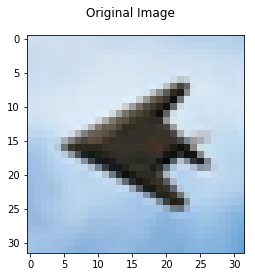

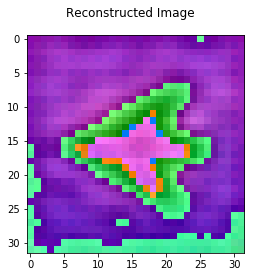

In [53]:
with tf.Session(graph = computation_graph) as sess:
    # load the weights from the model1
    saver = tf.train.Saver()
    
    # instead of global variable initializer, restore the graph:
    saver.restore(sess, tf.train.latest_checkpoint(new_model_path))
    
    prediction = sess.graph.get_tensor_by_name("prediction:0")
    inputs = sess.graph.get_tensor_by_name("inputs:0")
    
    random_image = batch_data[np.random.randint(len(batch_data))]
    reconstructed_image = sess.run(prediction, feed_dict={inputs: np.array([random_image])})[0]
    
    # plot the two images with their titles:
    plt.figure().suptitle("Original Image")
    plt.imshow(random_image, interpolation='none')
    
    plt.figure().suptitle("Reconstructed Image")
    plt.imshow(reconstructed_image, interpolation='none')